In [10]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy import misc
import tensorflow as tf
from libs import utils, gif
import IPython.display as ipyd
%matplotlib inline
plt.style.use('ggplot')
try:
    from libs import utils, gif
    import IPython.display as ipyd
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
#%matplotlib inline
#plt.style.use('ggplot')
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [9]:
#X = tf.placeholder(dtype=tf.float32,shape=None,name='X')
#W = tf.get_variable(dtype=tf.float32,shape=[2, 20],name='W',initializer=tf.random_normal_initializer()))
#h = tf.matmul(X,W)
#b = tf.get_variable(dtype=tf.float32,shape=[20],name='b',initializer=tf.constant_initializer(0.0))
utils.linear
def linear(x, n_output, name=None, activation=None, reuse=None):
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

h, W =utils.linear(x=X,n_output=20,name='linear',activation=relu)

<function libs.utils.linear>

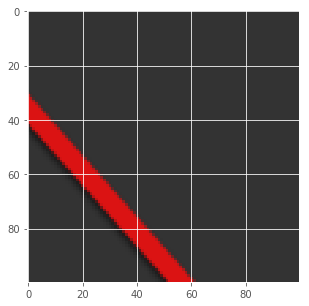

In [13]:
img = misc.imread('/home/anurag/Pictures/material/08.jpg')
img = imresize(img, (100,100))
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imsave(fname='reference.png', arr=img)

-1.71481604244 1.71481604244
0.0745098039216 0.858823529412


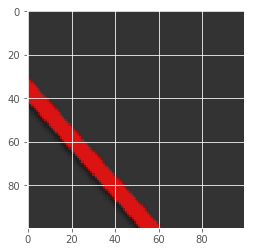

In [17]:
def split_image(img):
    # We'll first collect all the positions in the image in our list, xs
    xs = []

    # And the corresponding colors for each of these positions
    ys = []

    # Now loop over the image
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img[row_i, col_i])

    # we'll convert our lists to arrays
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

xs, ys = split_image(img)

# and print the shapes
xs.shape, ys.shape

xs = ( xs - np.mean(xs) )/np.std(xs)

print(np.min(xs), np.max(xs))
assert(np.min(xs) > -3.0 and np.max(xs) < 3.0)

ys = ys / 255.0
print(np.min(ys), np.max(ys))
plt.imshow(ys.reshape(img.shape))

In [24]:
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32,shape=[None,2],name='X')
Y = tf.placeholder(dtype=tf.float32,shape=[None,3],name='Y')
n_neurons=20
h1, W1 = utils.linear(X, n_neurons, name='layer1', activation=tf.nn.relu, reuse=None)
h2, W2 = utils.linear(h1,n_neurons,name='layer2',activation=tf.nn.relu,reuse=None)
h3, W3 = utils.linear(h2,n_neurons,name='layer3',activation=tf.nn.relu,reuse=None)
h4, W4 = utils.linear(h3,n_neurons,name='layer4',activation=tf.nn.relu,reuse=None)
h5, W5 = utils.linear(h4,n_neurons,name='layer5',activation=tf.nn.relu,reuse=None)
h6, W6 = utils.linear(h5,n_neurons,name='layer6',activation=tf.nn.relu,reuse=None)

Y_pred, W7 = utils.linear(h6, 3, activation=None, name='pred')
assert(X.get_shape().as_list() == [None, 2])
assert(Y_pred.get_shape().as_list() == [None, 3])
assert(Y.get_shape().as_list() == [None, 3])

error = np.power((Y - Y_pred),2)
assert(error.get_shape().as_list() == [None, 3])

cost = tf.reduce_mean(tf.reduce_sum(error))
assert(cost.get_shape().as_list() == [])

optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
n_iterations = 100
batch_size = 64
sess = tf.Session()


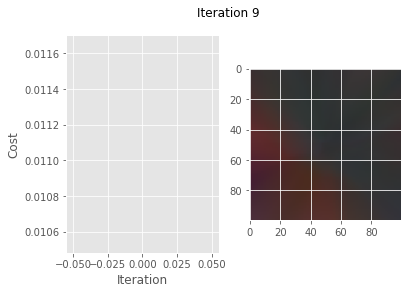

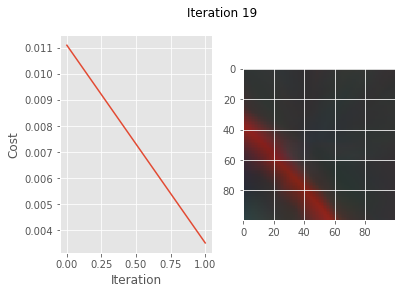

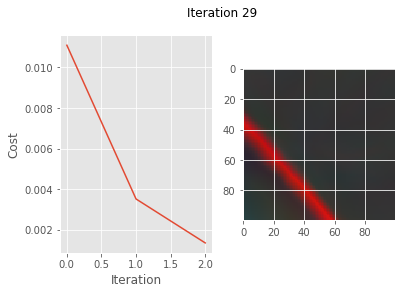

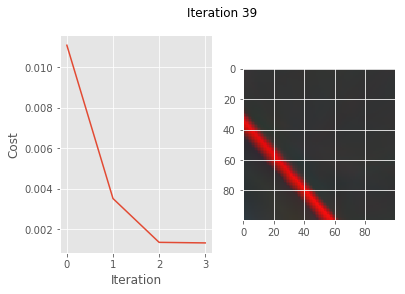

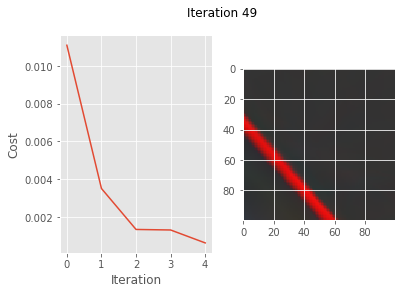

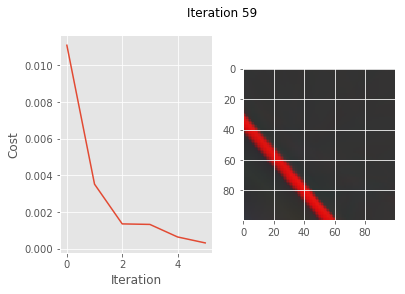

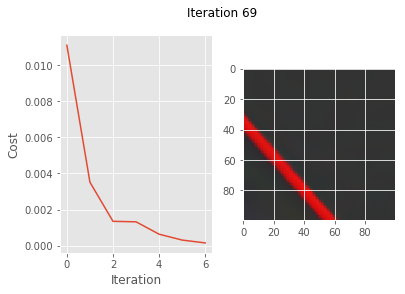

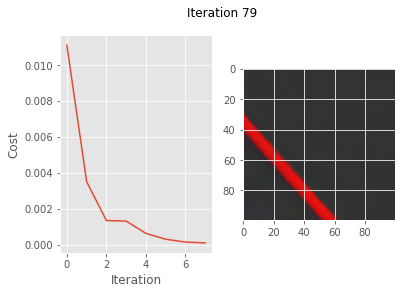

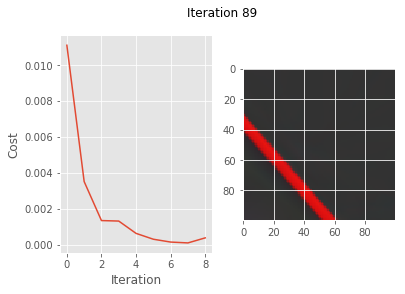

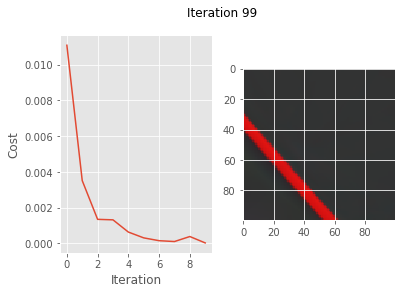

In [25]:
sess.run(tf.global_variables_initializer())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    
    # Get a random sampling of the dataset
    idxs = np.random.permutation(range(len(xs)))
    
    # The number of batches we have to iterate over
    n_batches = len(idxs) // batch_size
    
    # Now iterate over our stochastic minibatches:
    for batch_i in range(n_batches):
         
        # Get just minibatch amount of data
        idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]

        # And optimize, also returning the cost so we can monitor
        # how our optimization is doing.
        training_cost = sess.run(
            [cost, optimizer],
            feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]

    # Also, every 20 iterations, we'll draw the prediction of our
    # input xs, which should try to recreate our image!
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()